# Full Pipeline Tutorial for hiPSC-CM Video Analysis

This notebook runs the **entire** tutorial pipeline in three steps:
1. **Setup** – Prepare your Python environment  
2. **Inputs** – Define all your settings and paths  
3. **Execution** – Run segmentation, skip detection for speed, denoise, analyze, and extract features, then print and save the final metrics  

Detection is commented out to load precomputed results for faster iteration.

## Environment Setup Guide

Follow these steps to prepare your Python environment before running the notebook:

1. **Create a virtual environment**  
   ```bash
   python -m venv venv
   ```

2. **Activate the virtual environment**  
   - Linux/macOS:  
     ```bash
     source venv/bin/activate
     ```  
   - Windows (PowerShell):  
     ```powershell
     .\venv\Scripts\Activate.ps1
     ```

3. **Install required packages**  
   ```bash
   pip install -r requirements.txt
   ```

Make sure your `requirements.txt` file is in the same directory as this notebook.

In [1]:
# ==== USER INPUTS ====
from pathlib import Path

# Paths and filenames
INPUT_DIR = Path("data")            # Directory containing your ND2 file
OUTPUT_DIR = Path("results")        # Folder to save all outputs
ND2_FILENAME = "Quartz.2862.D1.Myk.baseline.GFP.m002.nd2"              # Change to your ND2 filename

# Prepare paths
VIDEO_STEM = Path(ND2_FILENAME).stem
nd2_path = INPUT_DIR / ND2_FILENAME
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Processing parameters
FRAME_RATE = 100.0       # frames per second of your video
PIXEL_TO_MICRON = 0.1625 # micron per pixel for conversion (adjust if needed)
FRAME_AVG_RANGE = 5      # Number of frames to average in feature extraction

# SarcGraph detection parameters
SARC_INPUT_TYPE = 'image'
ZDISC_MIN_LENGTH = 15
ZDISC_MAX_LENGTH = 75
SIGMA = 2.0
MIN_SARC_LENGTH = 7.5
AVG_SARC_LENGTH = 10.5
MAX_SARC_LENGTH = 13.5
NUM_NEIGHBORS = 5
ANGLE_THRESHOLD = 1.7

# Parallelization
NUM_PROCESSES = 2       # Adjust based on your CPU cores

print("✅ Inputs defined.")

✅ Inputs defined.


In [2]:
# ==== IMPORTS ====
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nd2
import json
from sarcgraph import SarcGraph

# Pipeline modules
from src.segmentation import process_frames_parallel_save_bbox_hull
from src.detection import process_all_frames_for_sarcomeres
from src.denoising import smooth_sarcomere_lengths_with_gpr
from src.analyze import analyze_signal, plot_signal_with_regions
from src.feature_extraction import extract_metrics

print("✅ Imports completed.")

✅ Imports completed.


In [8]:
# Load video frames
with nd2.ND2File(nd2_path) as f:
    print(f.metadata)


Metadata(contents=Contents(channelCount=1, frameCount=1519), channels=[Channel(channel=ChannelMeta(name='GFP_Yao', index=0, color=Color(r=0, g=255, b=0, a=1.0), emissionLambdaNm=515.0, excitationLambdaNm=473.0), loops=LoopIndices(NETimeLoop=None, TimeLoop=0, XYPosLoop=None, ZStackLoop=None), microscope=Microscope(objectiveMagnification=40.0, objectiveName='Apo 40x WI λS DIC N2', objectiveNumericalAperture=1.25, zoomMagnification=1.0, immersionRefractiveIndex=1.333, projectiveMagnification=1.0, pinholeDiameterUm=None, modalityFlags=['fluorescence', 'camera']), volume=Volume(axesCalibrated=(True, True, False), axesCalibration=(0.1625, 0.1625, 1.0), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=16, cameraTransformationMatrix=(0.9997337429126032, -0.023074732543563823, 0.023074732543563823, 0.9997337429126032), componentCount=1, componentDataType='unsigned', voxelCount=(1900, 450, 1), componentMaxima=[0.0], componentMinima

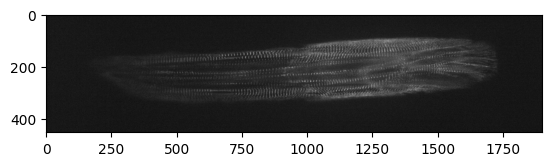

In [3]:
# Load video frames
with nd2.ND2File(nd2_path) as f:
    frames = np.array(f)

plt.imshow(frames[0], cmap='gray')

In [4]:
np.save('test_data.npy', frames[0:500])

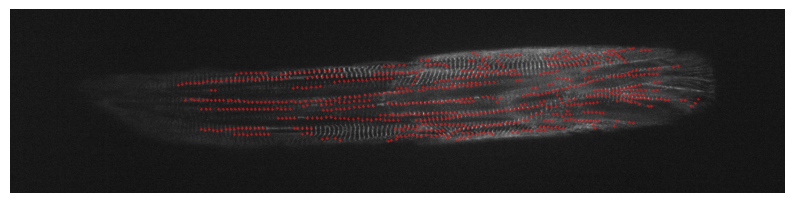

In [10]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(frames[0], cmap='gray')

np.save('test_frames.npy', frames[0])
plt.plot(zdiscs.y, zdiscs.x, 'r.', ms=1)
plt.savefig('test_sarcgraph.png', dpi=600, bbox_inches='tight')

In [4]:
# 1) Segmentation
print("🔸 Segmenting cells...")
bbox_path = f"{VIDEO_STEM}_segmentation_results.npz"
process_frames_parallel_save_bbox_hull(
    all_frames=frames[0:1],
    save_filename=bbox_path,
    num_processes=NUM_PROCESSES
)


# 2) Detection
print("🔸 Detecting sarcomeres and Z-discs...")
sg = SarcGraph(
    input_type=SARC_INPUT_TYPE,
    zdisc_min_length=ZDISC_MIN_LENGTH,
    zdisc_max_length=ZDISC_MAX_LENGTH,
    sigma=SIGMA,
    min_sarc_length=MIN_SARC_LENGTH,
    avg_sarc_length=AVG_SARC_LENGTH,
    max_sarc_length=MAX_SARC_LENGTH,
    num_neighbors=NUM_NEIGHBORS,
    angle_threshold=ANGLE_THRESHOLD
)
detect_path = f"{VIDEO_STEM}_detection_results"
process_all_frames_for_sarcomeres(
    all_frames=frames[0:1],
    sarcgraph_instance=sg,
    save_filename=detect_path,
    num_processes=NUM_PROCESSES
)

🔸 Segmenting cells...
INFO: Using 2 processes for parallel frame processing and saving to: Quartz.2862.D1.Myk.baseline.GFP.m002_segmentation_results.npz
INFO: Bounding box and convex hull data saved to: Quartz.2862.D1.Myk.baseline.GFP.m002_segmentation_results.npz
🔸 Detecting sarcomeres and Z-discs...
output_dir = output
input_type = image
save_output = True
sigma = 2.0
zdisc_min_length = 15
zdisc_max_length = 75
full_track_ratio = 0.75
tp_depth = 4
skip_merge = False
num_neighbors = 5
avg_sarc_length = 10.5
min_sarc_length = 7.5
max_sarc_length = 13.5
coeff_avg_length = 1.0
coeff_neighbor_length = 1.0
coeff_neighbor_angle = 1.0
score_threshold = 0.1
angle_threshold = 1.7
INFO: Using 2 processes for parallel sarcomere detection.
INFO: Aggregated Z-disc and Sarcomere data saved to: Quartz.2862.D1.Myk.baseline.GFP.m002_detection_results


In [6]:
zdiscs = pd.read_csv('Quartz.2862.D1.Myk.baseline.GFP_zdiscs.csv')

In [7]:
# ==== FULL PIPELINE EXECUTION ====
print("🚀 Running full hiPSC-CM analysis pipeline...")

# Load video frames
with nd2.ND2File(nd2_path) as f:
    frames = np.array(f)

# 1) Segmentation
print("🔸 Segmenting cells...")
bbox_path = OUTPUT_DIR / f"{VIDEO_STEM}_segmentation_results.npz"
process_frames_parallel_save_bbox_hull(
    all_frames=frames,
    save_filename=bbox_path,
    num_processes=NUM_PROCESSES
)

# 2) Detection
print("🔸 Detecting sarcomeres and Z-discs...")
sg = SarcGraph(
    input_type=SARC_INPUT_TYPE,
    zdisc_min_length=ZDISC_MIN_LENGTH,
    zdisc_max_length=ZDISC_MAX_LENGTH,
    sigma=SIGMA,
    min_sarc_length=MIN_SARC_LENGTH,
    avg_sarc_length=AVG_SARC_LENGTH,
    max_sarc_length=MAX_SARC_LENGTH,
    num_neighbors=NUM_NEIGHBORS,
    angle_threshold=ANGLE_THRESHOLD
)
detect_path = OUTPUT_DIR / f"{VIDEO_STEM}_detection_results"
process_all_frames_for_sarcomeres(
    all_frames=frames,
    sarcgraph_instance=sg,
    save_filename=detect_path,
    num_processes=NUM_PROCESSES
)

# 3) Denoising
print("🔸 Denoising sarcomere lengths...")
det_csv = OUTPUT_DIR / f"{VIDEO_STEM}_detection_results_sarcomeres.csv"
df_det = pd.read_csv(det_csv)
frame_nums = df_det.groupby("frame")["frame"].mean().values
lengths = df_det.groupby("frame")["length"].mean().values
denoise_csv = OUTPUT_DIR / f"{VIDEO_STEM}_denoised_sarcomere_length.csv"
smooth_lengths = smooth_sarcomere_lengths_with_gpr(
    frames=frame_nums,
    signal=lengths,
    output_path=denoise_csv,
    min_noise=1e-3,
    max_iter=500,
    derivative_threshold=0.00001,
    learning_rate=0.02,
)

# 4) Analysis
print("🔸 Analyzing contraction cycles...")
sm_df = pd.read_csv(denoise_csv)
frames_sm = sm_df["frame"].values
sig_sm = sm_df["length_smoothed"].values
noisy_vals = df_det.groupby("frame")["length"].mean().values
analysis_json = OUTPUT_DIR / f"{VIDEO_STEM}_cell_state.json"
analysis_results = analyze_signal(
    signal=sig_sm,
    time_array=frames_sm,
    output_path=analysis_json,
    max_ratio_threshold=0.8,
    derivative_threshold=0.005,
)

# 5) Feature Extraction
print("🔸 Extracting functional metrics...")
with open(analysis_json, "r") as f:
    analysis_dict = json.load(f)
bb_data = np.load(bbox_path, allow_pickle=True)
metrics = extract_metrics(
    sarcomere_data_df=df_det,
    smoothed_signal_array=sig_sm,
    analysis_results_dict=analysis_dict,
    bounding_boxes_px=bb_data["boxes"],
    convex_hulls_px=bb_data["hull_points"],
    PIXEL_TO_MICRON=PIXEL_TO_MICRON,
    FRAME_RATE=FRAME_RATE,
    FRAME_AVG_RANGE=FRAME_AVG_RANGE
)

# Display and save metrics
metrics_df = pd.Series(metrics).to_frame("value")
print("\n✅ Pipeline completed. Metrics:")
print(metrics_df)
metrics_df.to_csv(OUTPUT_DIR / f"{VIDEO_STEM}_metrics.csv")

print(f"All results and metrics saved in: {OUTPUT_DIR}")

🚀 Running full hiPSC-CM analysis pipeline...
🔸 Segmenting cells...
INFO: Using 2 processes for parallel frame processing and saving to: results/Quartz.2862.D1.Myk.baseline.GFP.m002_segmentation_results.npz
INFO: Processed frame 200/1519
INFO: Processed frame 400/1519
INFO: Processed frame 600/1519
INFO: Processed frame 800/1519
INFO: Processed frame 1000/1519
INFO: Processed frame 1200/1519
INFO: Processed frame 1400/1519
INFO: Bounding box and convex hull data saved to: results/Quartz.2862.D1.Myk.baseline.GFP.m002_segmentation_results.npz
🔸 Loading precomputed detection results...
🔸 Denoising sarcomere lengths...
Iter 20 / 500 - Loss: 0.657 | Noise: 0.520
Iter 40 / 500 - Loss: 0.476 | Noise: 0.373
Iter 60 / 500 - Loss: 0.288 | Noise: 0.259
Iter 80 / 500 - Loss: 0.091 | Noise: 0.175
Iter 100 / 500 - Loss: -0.102 | Noise: 0.117
Iter 120 / 500 - Loss: -0.296 | Noise: 0.077
Iter 140 / 500 - Loss: -0.505 | Noise: 0.051
Iter 160 / 500 - Loss: -0.701 | Noise: 0.033
Iter 180 / 500 - Loss: -0.

/projectnb/lejlab2/saeed/all-sarcgraph/adam-data-new-high-framerate/sarcgraph-video/.venv/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Saved smoothed signal to results/Quartz.2862.D1.Myk.baseline.GFP.m002_denoised_sarcomere_length.csv
🔸 Analyzing contraction cycles...
Saved analysis results to results/Quartz.2862.D1.Myk.baseline.GFP.m002_cell_state.json
🔸 Extracting functional metrics...

✅ Pipeline completed. Metrics:
                                                  value
num_contractions                               5.000000
contraction_period                             2.556000
contraction_frequency                          0.396313
relaxed_sarcomere_length_mean                  1.839844
relaxed_sarcomere_length_median                1.857137
relaxed_sarcomere_length_q25                   1.725172
relaxed_sarcomere_length_q75                   1.973581
relaxed_sarcomere_length_std                   0.188778
peak_sarcomere_length_mean                     1.698636
peak_sarcomere_length_median                   1.682460
peak_sarcomere_length_q25                      1.579154
peak_sarcomere_length_q75               

## Partitioned Metrics

This section computes functional metrics for **horizontal partitions** (left, center, right) of the tissue.  
It:
1. Loads the sarcomere detection CSV and bounding-box NPZ.  
2. Labels each sarcomere with `horizontal_region`.  
3. For each region:
   - Filters the DataFrame.
   - Computes mean sarcomere length per frame.
   - Runs GPR denoising with existing parameters.
   - Analyzes the smoothed signal.
   - Extracts and saves metrics with the region tag.

In [3]:
# ==== PARTITIONED METRICS INPUTS ====
from pathlib import Path

# Assume ND2_FILENAME, INPUT_DIR, OUTPUT_DIR, VIDEO_STEM already defined

# Detection results
DETECTION_CSV = OUTPUT_DIR / f"{VIDEO_STEM}_detection_results_sarcomeres.csv"
BOUNDING_BOX_NPZ = OUTPUT_DIR / f"{VIDEO_STEM}_segmentation_results.npz"

# Regions to process
HORIZONTAL_REGIONS = ['left', 'center', 'right']

print("✅ Partition inputs set.")

✅ Partition inputs set.


In [4]:
from src.partition import partition_sarcomere_data
from src.feature_extraction import extract_partition_metrics

In [32]:
# 1) Turn on autoreload at the top of your notebook (once):
%load_ext autoreload
%autoreload 2

# Now any time you save changes to src/analyze.py,
# the updated function will be picked up automatically.

# 2) Or, do it manually:
import importlib
import src.analyze as analyze_mod

importlib.reload(analyze_mod)               # re-reads your edited file
from src.analyze import analyze_signal

In [21]:
# 1) Annotate partitions
annotated_csv = OUTPUT_DIR / f"{VIDEO_STEM}_sarcomeres_partitioned.csv"
df_part = partition_sarcomere_data(
    sarcomere_csv=DETECTION_CSV,
    bounding_box_npz=BOUNDING_BOX_NPZ,
    output_csv=annotated_csv
)

# 2) Loop over regions
all_metrics = {}
for region in HORIZONTAL_REGIONS:
    print(f"--- Processing region: {region} ---")
    df_reg = df_part[df_part.horizontal_region == region]
    if df_reg.empty:
        print(f"⚠ No sarcomeres found in region {region}, skipping.")
        continue

    # Mean length per frame
    frames = df_reg.groupby('frame')['frame'].mean().values
    lengths = df_reg.groupby('frame')['length'].mean().values

    # Denoise
    denoise_path = OUTPUT_DIR / f"{VIDEO_STEM}_{region}_denoised.csv"
    smooth = smooth_sarcomere_lengths_with_gpr(
        frames=frames,
        signal=lengths,
        output_path=denoise_path,
        min_noise=1e-3,
        max_iter=500,
        derivative_threshold=0.00001,
        learning_rate=0.02,
    )

    # Analyze
    analysis_json = OUTPUT_DIR / f"{VIDEO_STEM}_{region}_analysis.json"
    analysis = analyze_signal(
        signal=smooth,
        time_array=frames,
        output_path=analysis_json,
        max_ratio_threshold=0.8,
        derivative_threshold=0.005,
    )

    # Extract metrics
    metrics = extract_partition_metrics(
        sarcomere_data_df=df_reg,
        smoothed_signal_array=smooth,
        analysis_results_dict=analysis,
        PIXEL_TO_MICRON=PIXEL_TO_MICRON,
        FRAME_RATE=FRAME_RATE,
        FRAME_AVG_RANGE=FRAME_AVG_RANGE
    )
    all_metrics[region] = metrics

    # Save to CSV
    pd.Series(metrics).to_frame("value").to_csv(
        OUTPUT_DIR / f"{VIDEO_STEM}_{region}_metrics.csv"
    )
    print(f"✅ Metrics for region {region} saved.")

Saved partition-labeled sarcomere data to results/Quartz.2862.D1.Myk.baseline.GFP.m002_sarcomeres_partitioned.csv
--- Processing region: left ---
Iter 20 / 500 - Loss: 0.640 | Noise: 0.520
Iter 40 / 500 - Loss: 0.476 | Noise: 0.372
Iter 60 / 500 - Loss: 0.289 | Noise: 0.258
Iter 80 / 500 - Loss: 0.105 | Noise: 0.175
Iter 100 / 500 - Loss: -0.072 | Noise: 0.117
Iter 120 / 500 - Loss: -0.265 | Noise: 0.078
Iter 140 / 500 - Loss: -0.455 | Noise: 0.052
Iter 160 / 500 - Loss: -0.609 | Noise: 0.034
Iter 180 / 500 - Loss: -0.758 | Noise: 0.023
Iter 200 / 500 - Loss: -0.885 | Noise: 0.015
Iter 220 / 500 - Loss: -0.983 | Noise: 0.011
Iter 240 / 500 - Loss: -1.041 | Noise: 0.008
Iter 260 / 500 - Loss: -1.098 | Noise: 0.006
Iter 280 / 500 - Loss: -1.093 | Noise: 0.005
Iter 300 / 500 - Loss: -1.090 | Noise: 0.004
Iter 320 / 500 - Loss: -1.088 | Noise: 0.004
Iter 340 / 500 - Loss: -1.054 | Noise: 0.003


/projectnb/lejlab2/saeed/all-sarcgraph/adam-data-new-high-framerate/sarcgraph-video/.venv/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Saved smoothed signal to results/Quartz.2862.D1.Myk.baseline.GFP.m002_left_denoised.csv
Saved analysis results to results/Quartz.2862.D1.Myk.baseline.GFP.m002_left_analysis.json
✅ Metrics for region left saved.
--- Processing region: center ---
Iter 20 / 500 - Loss: 0.672 | Noise: 0.520
Iter 40 / 500 - Loss: 0.486 | Noise: 0.371
Iter 60 / 500 - Loss: 0.294 | Noise: 0.257
Iter 80 / 500 - Loss: 0.106 | Noise: 0.173
Iter 100 / 500 - Loss: -0.082 | Noise: 0.115
Iter 120 / 500 - Loss: -0.280 | Noise: 0.076
Iter 140 / 500 - Loss: -0.477 | Noise: 0.050
Iter 160 / 500 - Loss: -0.657 | Noise: 0.033
Iter 180 / 500 - Loss: -0.823 | Noise: 0.022
Iter 200 / 500 - Loss: -0.957 | Noise: 0.015
Iter 220 / 500 - Loss: -1.088 | Noise: 0.010
Iter 240 / 500 - Loss: -1.172 | Noise: 0.007
Iter 260 / 500 - Loss: -1.224 | Noise: 0.005
Iter 280 / 500 - Loss: -1.235 | Noise: 0.004
Iter 300 / 500 - Loss: -1.244 | Noise: 0.003
Iter 320 / 500 - Loss: -1.240 | Noise: 0.003
Iter 340 / 500 - Loss: -1.204 | Noise: 0.00

/projectnb/lejlab2/saeed/all-sarcgraph/adam-data-new-high-framerate/sarcgraph-video/.venv/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Saved smoothed signal to results/Quartz.2862.D1.Myk.baseline.GFP.m002_center_denoised.csv
Saved analysis results to results/Quartz.2862.D1.Myk.baseline.GFP.m002_center_analysis.json
✅ Metrics for region center saved.
--- Processing region: right ---
Iter 20 / 500 - Loss: 0.632 | Noise: 0.520
Iter 40 / 500 - Loss: 0.466 | Noise: 0.373
Iter 60 / 500 - Loss: 0.296 | Noise: 0.260
Iter 80 / 500 - Loss: 0.105 | Noise: 0.177
Iter 100 / 500 - Loss: -0.082 | Noise: 0.119
Iter 120 / 500 - Loss: -0.264 | Noise: 0.079
Iter 140 / 500 - Loss: -0.443 | Noise: 0.053
Iter 160 / 500 - Loss: -0.606 | Noise: 0.036
Iter 180 / 500 - Loss: -0.739 | Noise: 0.024
Iter 200 / 500 - Loss: -0.825 | Noise: 0.017
Iter 220 / 500 - Loss: -0.861 | Noise: 0.013
Iter 240 / 500 - Loss: -0.878 | Noise: 0.010
Iter 260 / 500 - Loss: -0.868 | Noise: 0.008
Iter 280 / 500 - Loss: -0.863 | Noise: 0.007
Iter 300 / 500 - Loss: -0.860 | Noise: 0.007
Iter 320 / 500 - Loss: -0.876 | Noise: 0.006


/projectnb/lejlab2/saeed/all-sarcgraph/adam-data-new-high-framerate/sarcgraph-video/.venv/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Saved smoothed signal to results/Quartz.2862.D1.Myk.baseline.GFP.m002_right_denoised.csv
Saved analysis results to results/Quartz.2862.D1.Myk.baseline.GFP.m002_right_analysis.json
✅ Metrics for region right saved.


## Full Partitioned Metrics

Now compute metrics for **all partition combinations** (horizontal: left, center, right × vertical: top, bottom).  
For each partition:
1. Filter the annotated DataFrame by both `horizontal_region` and `vertical_region`.  
2. Compute mean sarcomere length per frame.  
3. Apply GPR denoising.  
4. Analyze the smoothed signal.  
5. Extract and save metrics with the partition tag.

In [16]:
# ==== FULL PARTITIONED METRICS INPUTS ====
# Vertical regions to process
VERTICAL_REGIONS = ['top', 'bottom']

print("✅ Full partition inputs set.")

✅ Full partition inputs set.


In [14]:
# ==== FULL PARTITIONED METRICS EXECUTION ====
all_metrics_full = {}
for h in HORIZONTAL_REGIONS:
    for v in VERTICAL_REGIONS:
        part_name = f"{h}_{v}"
        print(f"--- Processing partition: {part_name} ---")
        df_sub = df_part[
            (df_part.horizontal_region == h) &
            (df_part.vertical_region   == v)
        ]
        if df_sub.empty:
            print(f"⚠ No data for {part_name}, skipping.")
            continue

        # Mean length per frame
        frames = df_sub.groupby('frame')['frame'].mean().values
        lengths = df_sub.groupby('frame')['length'].mean().values

        # Denoise
        denoise_path = OUTPUT_DIR / f"{VIDEO_STEM}_{part_name}_denoised.csv"
        smooth = smooth_sarcomere_lengths_with_gpr(
            frames=frames,
            signal=lengths,
            output_path=denoise_path,
            min_noise=1e-3,
            max_iter=500,
            derivative_threshold=0.00001,
            learning_rate=0.02,
        )


        # Analyze
        analysis_json_full = OUTPUT_DIR / f"{VIDEO_STEM}_{part_name}_analysis.json"
        analysis_full = analyze_signal(
            signal=smooth,
            time_array=frames,
            output_path=analysis_json_full,
            max_ratio_threshold=0.8,
            derivative_threshold=0.005,
        )

        # Extract metrics
        metrics_full = extract_partition_metrics(
            sarcomere_data_df      = df_sub,
            smoothed_signal_array  = smooth,
            analysis_results_dict  = analysis_full,
            PIXEL_TO_MICRON        = PIXEL_TO_MICRON,
            FRAME_RATE             = FRAME_RATE,
            FRAME_AVG_RANGE        = FRAME_AVG_RANGE
        )
        all_metrics_full[part_name] = metrics_full

        # Save to CSV
        import pandas as pd
        pd.Series(metrics_full).to_frame("value").to_csv(
            OUTPUT_DIR / f"{VIDEO_STEM}_{part_name}_metrics.csv"
        )
        print(f"✅ Metrics for {part_name} saved.")

# Display summary
import pandas as pd
full_summary_df = pd.DataFrame(all_metrics_full).T
print("\nFull Partitioned Metrics Summary:")
print(full_summary_df)

--- Processing partition: left_top ---
Iter 20 / 500 - Loss: 0.635 | Noise: 0.520
Iter 40 / 500 - Loss: 0.475 | Noise: 0.372
Iter 60 / 500 - Loss: 0.294 | Noise: 0.258
Iter 80 / 500 - Loss: 0.116 | Noise: 0.176
Iter 100 / 500 - Loss: -0.068 | Noise: 0.118
Iter 120 / 500 - Loss: -0.253 | Noise: 0.079
Iter 140 / 500 - Loss: -0.433 | Noise: 0.053
Iter 160 / 500 - Loss: -0.571 | Noise: 0.035
Iter 180 / 500 - Loss: -0.736 | Noise: 0.024
Iter 200 / 500 - Loss: -0.822 | Noise: 0.016
Iter 220 / 500 - Loss: -0.889 | Noise: 0.012
Iter 240 / 500 - Loss: -0.971 | Noise: 0.009
Iter 260 / 500 - Loss: -0.961 | Noise: 0.007
Iter 280 / 500 - Loss: -0.970 | Noise: 0.006
Iter 300 / 500 - Loss: -0.968 | Noise: 0.005
Iter 320 / 500 - Loss: -0.957 | Noise: 0.005


/projectnb/lejlab2/saeed/all-sarcgraph/adam-data-new-high-framerate/sarcgraph-video/.venv/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Saved smoothed signal to results/Quartz.2862.D1.Myk.baseline.GFP.m002_left_top_denoised.npy
Saved analysis results to results/Quartz.2862.D1.Myk.baseline.GFP.m002_left_top_analysis.json
✅ Metrics for left_top saved.
--- Processing partition: left_bottom ---
Iter 20 / 500 - Loss: 0.645 | Noise: 0.520
Iter 40 / 500 - Loss: 0.484 | Noise: 0.371
Iter 60 / 500 - Loss: 0.317 | Noise: 0.257
Iter 80 / 500 - Loss: 0.133 | Noise: 0.175
Iter 100 / 500 - Loss: -0.040 | Noise: 0.118
Iter 120 / 500 - Loss: -0.192 | Noise: 0.079
Iter 140 / 500 - Loss: -0.349 | Noise: 0.054
Iter 160 / 500 - Loss: -0.458 | Noise: 0.036
Iter 180 / 500 - Loss: -0.523 | Noise: 0.026
Iter 200 / 500 - Loss: -0.581 | Noise: 0.019
Iter 220 / 500 - Loss: -0.596 | Noise: 0.015
Iter 240 / 500 - Loss: -0.603 | Noise: 0.013
Iter 260 / 500 - Loss: -0.588 | Noise: 0.011
Iter 280 / 500 - Loss: -0.587 | Noise: 0.010


/projectnb/lejlab2/saeed/all-sarcgraph/adam-data-new-high-framerate/sarcgraph-video/.venv/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Saved smoothed signal to results/Quartz.2862.D1.Myk.baseline.GFP.m002_left_bottom_denoised.npy
Saved analysis results to results/Quartz.2862.D1.Myk.baseline.GFP.m002_left_bottom_analysis.json
✅ Metrics for left_bottom saved.
--- Processing partition: center_top ---
Iter 20 / 500 - Loss: 0.636 | Noise: 0.520
Iter 40 / 500 - Loss: 0.467 | Noise: 0.371
Iter 60 / 500 - Loss: 0.287 | Noise: 0.257
Iter 80 / 500 - Loss: 0.102 | Noise: 0.175
Iter 100 / 500 - Loss: -0.083 | Noise: 0.117
Iter 120 / 500 - Loss: -0.268 | Noise: 0.078
Iter 140 / 500 - Loss: -0.443 | Noise: 0.052
Iter 160 / 500 - Loss: -0.591 | Noise: 0.034
Iter 180 / 500 - Loss: -0.741 | Noise: 0.023
Iter 200 / 500 - Loss: -0.835 | Noise: 0.016
Iter 220 / 500 - Loss: -0.901 | Noise: 0.012
Iter 240 / 500 - Loss: -0.935 | Noise: 0.009
Iter 260 / 500 - Loss: -0.959 | Noise: 0.007
Iter 280 / 500 - Loss: -0.983 | Noise: 0.006
Iter 300 / 500 - Loss: -0.941 | Noise: 0.005
Iter 320 / 500 - Loss: -0.940 | Noise: 0.005


/projectnb/lejlab2/saeed/all-sarcgraph/adam-data-new-high-framerate/sarcgraph-video/.venv/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Saved smoothed signal to results/Quartz.2862.D1.Myk.baseline.GFP.m002_center_top_denoised.npy
Saved analysis results to results/Quartz.2862.D1.Myk.baseline.GFP.m002_center_top_analysis.json
✅ Metrics for center_top saved.
--- Processing partition: center_bottom ---
Iter 20 / 500 - Loss: 0.679 | Noise: 0.520
Iter 40 / 500 - Loss: 0.497 | Noise: 0.371
Iter 60 / 500 - Loss: 0.311 | Noise: 0.257
Iter 80 / 500 - Loss: 0.118 | Noise: 0.174
Iter 100 / 500 - Loss: -0.070 | Noise: 0.116
Iter 120 / 500 - Loss: -0.263 | Noise: 0.076
Iter 140 / 500 - Loss: -0.453 | Noise: 0.050
Iter 160 / 500 - Loss: -0.632 | Noise: 0.033
Iter 180 / 500 - Loss: -0.767 | Noise: 0.022
Iter 200 / 500 - Loss: -0.912 | Noise: 0.015
Iter 220 / 500 - Loss: -1.021 | Noise: 0.010
Iter 240 / 500 - Loss: -1.033 | Noise: 0.008
Iter 260 / 500 - Loss: -1.050 | Noise: 0.006
Iter 280 / 500 - Loss: -1.079 | Noise: 0.005
Iter 300 / 500 - Loss: -1.059 | Noise: 0.004
Iter 320 / 500 - Loss: -1.032 | Noise: 0.004


/projectnb/lejlab2/saeed/all-sarcgraph/adam-data-new-high-framerate/sarcgraph-video/.venv/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Saved smoothed signal to results/Quartz.2862.D1.Myk.baseline.GFP.m002_center_bottom_denoised.npy
Saved analysis results to results/Quartz.2862.D1.Myk.baseline.GFP.m002_center_bottom_analysis.json
✅ Metrics for center_bottom saved.
--- Processing partition: right_top ---
Iter 20 / 500 - Loss: 0.645 | Noise: 0.520
Iter 40 / 500 - Loss: 0.479 | Noise: 0.374
Iter 60 / 500 - Loss: 0.308 | Noise: 0.261
Iter 80 / 500 - Loss: 0.138 | Noise: 0.178
Iter 100 / 500 - Loss: -0.035 | Noise: 0.121
Iter 120 / 500 - Loss: -0.193 | Noise: 0.082
Iter 140 / 500 - Loss: -0.335 | Noise: 0.057
Iter 160 / 500 - Loss: -0.453 | Noise: 0.040
Iter 180 / 500 - Loss: -0.496 | Noise: 0.029
Iter 200 / 500 - Loss: -0.515 | Noise: 0.022
Iter 220 / 500 - Loss: -0.525 | Noise: 0.018
Iter 240 / 500 - Loss: -0.510 | Noise: 0.016
Iter 260 / 500 - Loss: -0.502 | Noise: 0.015
Iter 280 / 500 - Loss: -0.524 | Noise: 0.014


/projectnb/lejlab2/saeed/all-sarcgraph/adam-data-new-high-framerate/sarcgraph-video/.venv/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Saved smoothed signal to results/Quartz.2862.D1.Myk.baseline.GFP.m002_right_top_denoised.npy
Saved analysis results to results/Quartz.2862.D1.Myk.baseline.GFP.m002_right_top_analysis.json
✅ Metrics for right_top saved.
--- Processing partition: right_bottom ---
Iter 20 / 500 - Loss: 0.640 | Noise: 0.520
Iter 40 / 500 - Loss: 0.476 | Noise: 0.373
Iter 60 / 500 - Loss: 0.305 | Noise: 0.260
Iter 80 / 500 - Loss: 0.124 | Noise: 0.178
Iter 100 / 500 - Loss: -0.056 | Noise: 0.120
Iter 120 / 500 - Loss: -0.236 | Noise: 0.080
Iter 140 / 500 - Loss: -0.394 | Noise: 0.054
Iter 160 / 500 - Loss: -0.527 | Noise: 0.037
Iter 180 / 500 - Loss: -0.606 | Noise: 0.026
Iter 200 / 500 - Loss: -0.648 | Noise: 0.019
Iter 220 / 500 - Loss: -0.687 | Noise: 0.015
Iter 240 / 500 - Loss: -0.694 | Noise: 0.013
Iter 260 / 500 - Loss: -0.715 | Noise: 0.011
Iter 280 / 500 - Loss: -0.651 | Noise: 0.011
Iter 300 / 500 - Loss: -0.688 | Noise: 0.010


/projectnb/lejlab2/saeed/all-sarcgraph/adam-data-new-high-framerate/sarcgraph-video/.venv/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Saved smoothed signal to results/Quartz.2862.D1.Myk.baseline.GFP.m002_right_bottom_denoised.npy
Saved analysis results to results/Quartz.2862.D1.Myk.baseline.GFP.m002_right_bottom_analysis.json
✅ Metrics for right_bottom saved.

Full Partitioned Metrics Summary:
               num_contractions  contraction_period  contraction_frequency  \
left_top                    6.0            2.231667               0.566690   
left_bottom                 7.0            1.814286               0.802259   
center_top                  6.0            2.126667               0.691735   
center_bottom               5.0            2.532000               0.395313   
right_top                   5.0            2.538000               0.397331   
right_bottom                5.0            2.548000               0.393832   

               relaxed_sarcomere_length_mean  relaxed_sarcomere_length_median  \
left_top                            1.866452                         1.869112   
left_bottom                 

In [27]:
import pandas as pd
from pathlib import Path

# (Assumes OUTPUT_DIR, VIDEO_STEM, HORIZONTAL_REGIONS, VERTICAL_REGIONS are already defined)

# 1) Whole‐cell metrics
full_metrics = pd.read_csv(OUTPUT_DIR / f"{VIDEO_STEM}_metrics.csv", index_col=0)

# 2) Horizontal partitions
horiz_list = []
for region in HORIZONTAL_REGIONS:
    path = OUTPUT_DIR / f"{VIDEO_STEM}_{region}_metrics.csv"
    if path.exists():
        df = pd.read_csv(path, index_col=0)
        df = df.rename(columns={'value': region}).T
        horiz_list.append(df)
horizontal_metrics = pd.concat(horiz_list)

# 3) Full partitions (h × v)
part_list = []
for h in HORIZONTAL_REGIONS:
    for v in VERTICAL_REGIONS:
        key = f"{h}_{v}"
        path = OUTPUT_DIR / f"{VIDEO_STEM}_{key}_metrics.csv"
        if path.exists():
            df = pd.read_csv(path, index_col=0)
            df = df.rename(columns={'value': key}).T
            part_list.append(df)
full_partition_metrics = pd.concat(part_list)

# 4) Write to Excel with xlsxwriter
out_excel = OUTPUT_DIR / f"{VIDEO_STEM}_all_metrics.xlsx"
with pd.ExcelWriter(out_excel) as writer:
    full_metrics.to_excel(writer, sheet_name='whole_cell')
    horizontal_metrics.to_excel(writer, sheet_name='3_segments')
    full_partition_metrics.to_excel(writer, sheet_name='6_partitions')

print(f"✅ All metrics compiled into {out_excel}")


✅ All metrics compiled into results/Quartz.2862.D1.Myk.baseline.GFP.m002_all_metrics.xlsx
